In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import math
import os

In [4]:
# 部分シーケンス行列 Xw (delay coordinates matrix) を作成する関数
# plase also see def 1 & procedure 1
def delay_coordinates(X, w):
  m  = X.shape[0]//w # m: sequence length len_X = len(X) 
  n = w if len(X.shape) == 1 else X.shape[1]*w
  Xw = np.zeros((m, n))  # matrix Xw --- size:[mp x w] 
  for t in range(1, m+1):  # t = (1, ..., mp)
    Xw[t-1,:] = X[(t-1)*w:t*w].reshape(1, -1)  
  return Xw

def my_svd(Xw, k):
  # 特異値分解 - decompose Xw -> (U, s, Vh) 
  [U, s, Vh] = linalg.svd(Xw, full_matrices=False)

  # top-k成分を使った近似 - low-rank approximation
  U_k = U[:,0:k]; Vh_k = Vh[0:k,:]
  return (U_k, s, Vh_k)

In [5]:
def reconstruct(X, w, k):
 # (a) 部分シーケンス行列 Xw (delay coordinates matrix) の作成
  Xw = delay_coordinates(X, w) # 部分シーケンス行列を作成
  #print(f'create delay coordinates matrix (w={w}),   X: {X.shape} ->  Xw: {Xw.shape}')
  # (b) SVDを用いた行列分解
  (U, s, Vh) = my_svd(Xw, k)

  # (c) 分解した行列を用いたオリジナルデータの復元と可視化
  # k個の成分のみ選択して近似
  #Xw_rec  = np.dot(np.dot(U[:,0:k], np.diag(s[0:k])),Vh[0:k,:]) # delay coordinates matrix
  
  # (d) 誤差を求める
  err = sum(s[k:]**2) / w
  
  return Vh, U @ np.diag(s[0:k]), s[0:k], err

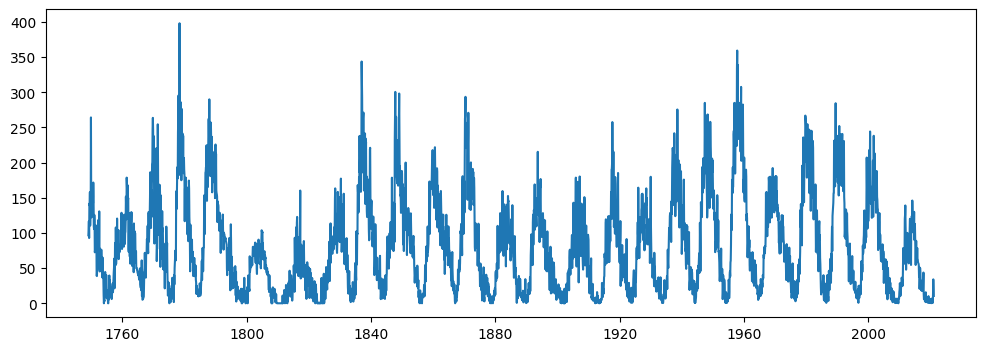

In [8]:
import pandas as pd

df = pd.read_csv('../project3/Sunspots.csv')
X = df['Monthly Mean Total Sunspot Number'].values
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(df['Date']), df['Monthly Mean Total Sunspot Number'])
plt.show()

In [9]:
def hierarchical_svd(X, w0, W, k, L=None):
  if L == None:
    L = int(math.log2(len(X)/w0))
  error_dict = dict()
  V0_ls = []

  Vh_l, Ph_l, sh_l, err = reconstruct(X, w0, k)
  V0_ls.append(Vh_l.T)
  error_dict[w0] = err
  print('----------------------------------------------------------------')
  print('L=0')
  print(f'window size: {w0}')
  print(f'time delay (shape): ({len(X)}, 1) → ({len(X)//w0}, {Vh_l.shape[1]})')
  print(f'SVD (shape): ({len(X)//w0}, {Vh_l.shape[1]}) = {Ph_l.shape} @ {Vh_l.shape}')
  print(f'reconstruction')
  plt.figure(figsize=(12, 4))
  plt.plot(X, label='original')
  plt.plot(np.ravel(Ph_l@Vh_l), label='reconstructions')
  plt.legend()
  plt.show()
  print('----------------------------------------------------------------')


  for l in range(1, L):
    w_l = w0*W**l

    print(f'L=l')
    print(f'window size: {w_l}')
    print(f'time delay (shape): {Ph_l.shape} → ({Ph_l.shape[0]//w0}, {W*Ph_l.shape[1]})')

    Vh_l, Ph_l, sh_l, err = reconstruct(Ph_l, W, k)
    V0_ls.append(np.zeros((w_l, k)))
    error_dict[w_l] = err
    
    for i in range(k):
      for j in range(W):
        V0_ls[l][:, i][j*w_l//W:(j+1)*w_l//W] = V0_ls[l-1]@Vh_l.T[:, i][j*k: (j+1)*k]

    print(f'SVD (shape): ({Ph_l.shape[0]//w0}, {W*Ph_l.shape[1]}) = {Ph_l.shape} @ {Vh_l.shape}')
    print(f'reconstruction: X_rec = (P @ V0).flatten()')
    plt.figure(figsize=(12, 4))
    plt.plot(X, label='original')
    plt.plot(np.ravel(Ph_l@V0_ls[l].T), label='reconstructions')
    plt.legend()
    plt.show()
    print('----------------------------------------------------------------')

  return Ph_l, V0_ls, error_dict

----------------------------------------------------------------
L=0
window size: 10
time delay (shape): (3265, 1) → (326, 10)
SVD (shape): (326, 10) = (326, 6) @ (6, 10)
reconstruction


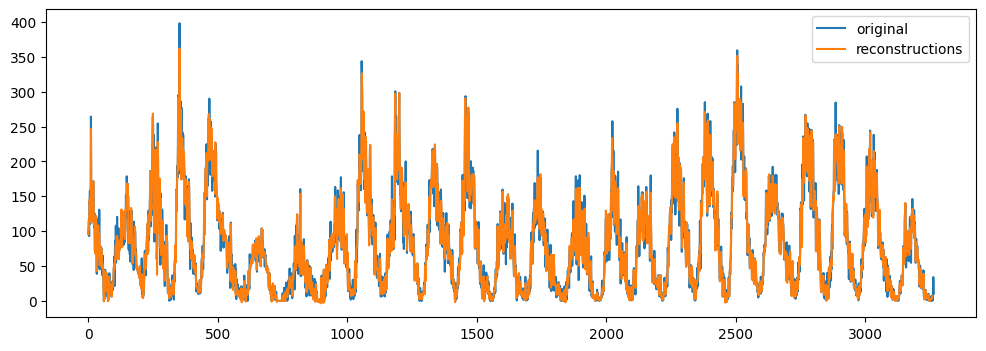

----------------------------------------------------------------
L=l
window size: 20
time delay (shape): (326, 6) → (32, 12)
SVD (shape): (16, 12) = (163, 6) @ (6, 12)
reconstruction: X_rec = (P @ V0).flatten()


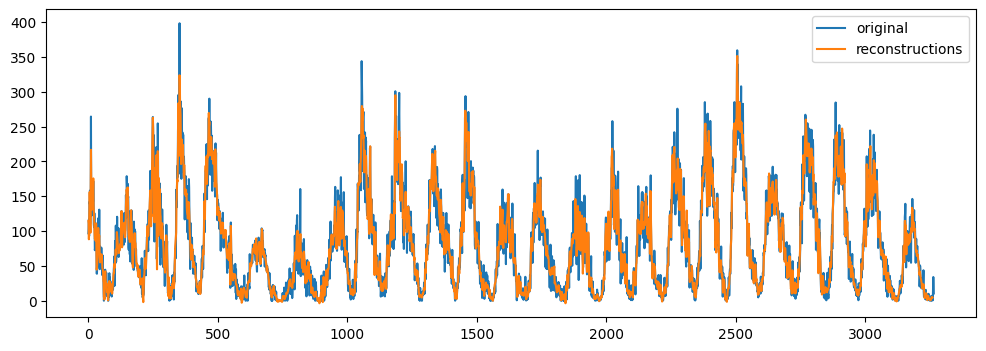

----------------------------------------------------------------
L=l
window size: 40
time delay (shape): (163, 6) → (16, 12)
SVD (shape): (8, 12) = (81, 6) @ (6, 12)
reconstruction: X_rec = (P @ V0).flatten()


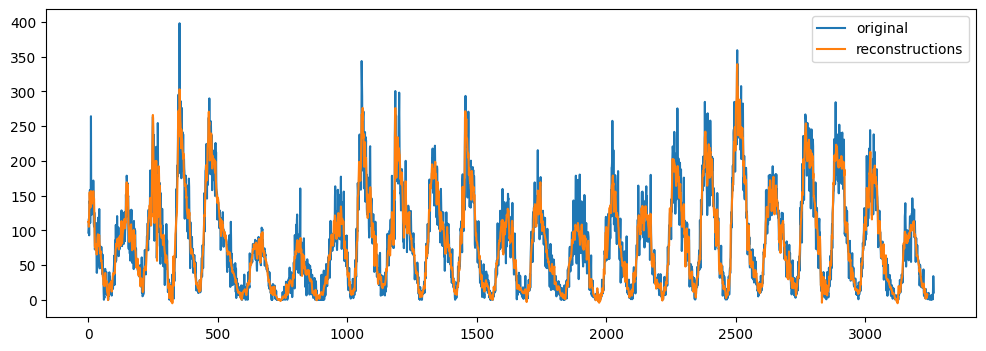

----------------------------------------------------------------
L=l
window size: 80
time delay (shape): (81, 6) → (8, 12)
SVD (shape): (4, 12) = (40, 6) @ (6, 12)
reconstruction: X_rec = (P @ V0).flatten()


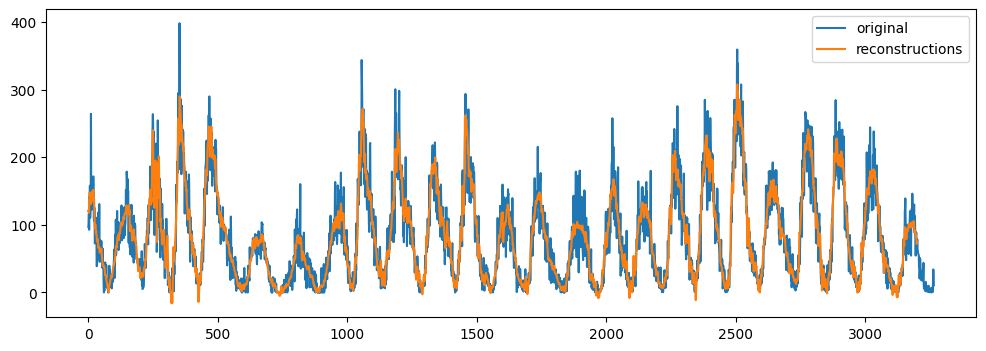

----------------------------------------------------------------
L=l
window size: 160
time delay (shape): (40, 6) → (4, 12)
SVD (shape): (2, 12) = (20, 6) @ (6, 12)
reconstruction: X_rec = (P @ V0).flatten()


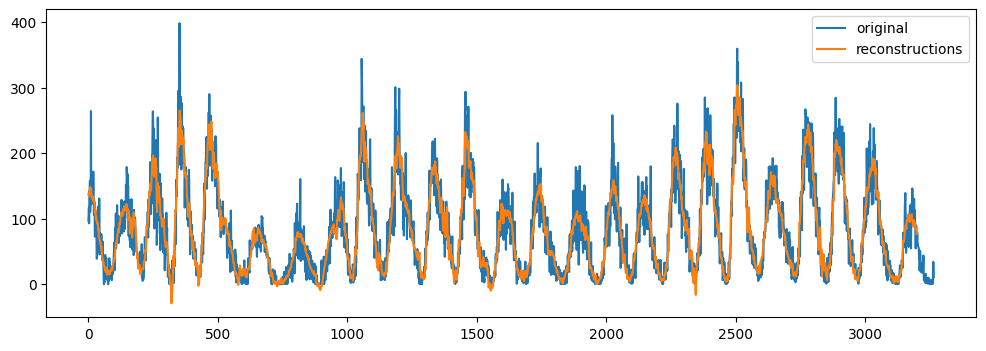

----------------------------------------------------------------
L=l
window size: 320
time delay (shape): (20, 6) → (2, 12)
SVD (shape): (1, 12) = (10, 6) @ (6, 12)
reconstruction: X_rec = (P @ V0).flatten()


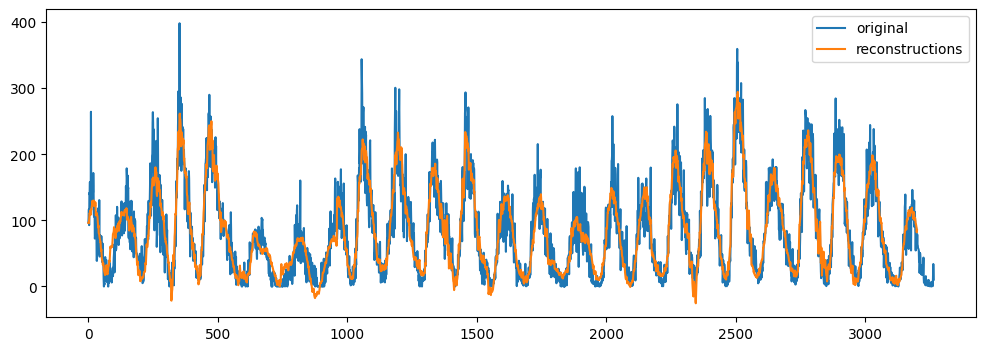

----------------------------------------------------------------


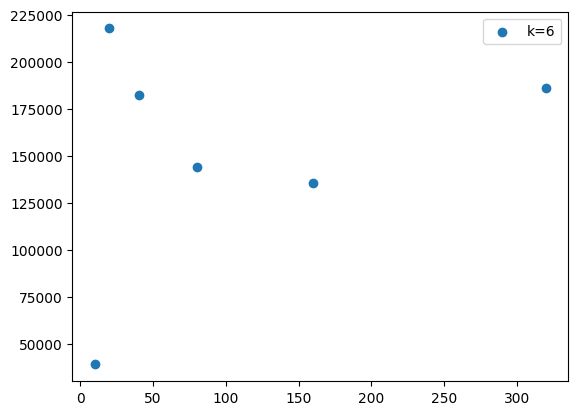

In [10]:
W = 2
w0 = [10]
k = [6]
error_list = []
for w_0 in w0:
    for i in k:
        P, V0, _error_dict = hierarchical_svd(X, w_0, W, i, 6)
        error_list.append(_error_dict)

for i in range(len(k)):
  plt.scatter(error_list[i].keys(), error_list[i].values(), label='k='+str(k[i]))

plt.legend()

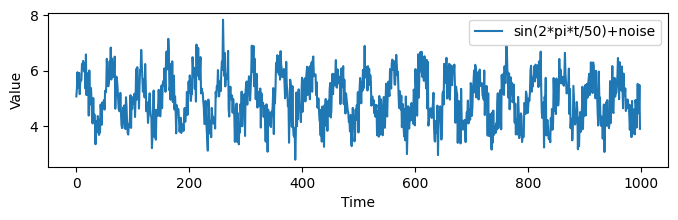

In [11]:
import random
from random import gauss
random.seed(314)
noise  = [gauss(5.0, 0.5) for i in range(1000)]
time   = np.arange(0, 1000, 1);
X = np.sin(2 * np.pi * time / 50) + noise
# 生成した時系列データの可視化
plt.figure(figsize=(8,2))
plt.plot(X, label='sin(2*pi*t/50)+noise')
plt.xlabel('Time'); plt.ylabel('Value')
plt.legend()

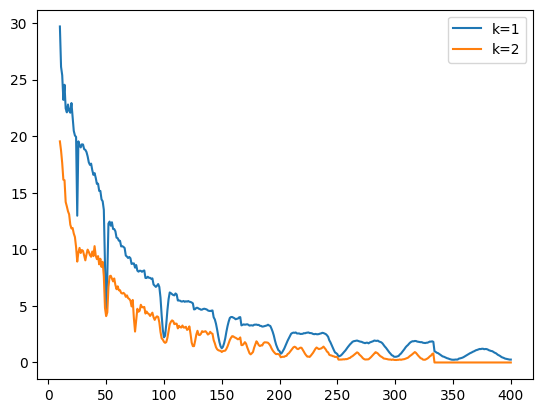

In [12]:
#Power profile
error = [[], []]
k = 2
for k in range(1, 3):
  for w0 in range(10, 401):
    _, _, _, err = reconstruct(X, w0, k)
    error[k-1].append(err)

plt.plot(np.arange(10, 401), error[0], label='k=1')
plt.plot(np.arange(10, 401), error[1], label='k=2')
plt.legend()
plt.show()